In [1]:
import os
os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Cluster_Training/')
import pandas as pd
import matplotlib as mpl
import numpy as np
np.seterr(divide = 'ignore')


mpl.rcParams['figure.dpi'] = 120

%config IPCompleter.use_jedi = False
%matplotlib inline

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.proportion import proportions_ztest
from sklearn.manifold import TSNE
import seaborn as sns
from upsetplot import plot
import pickle

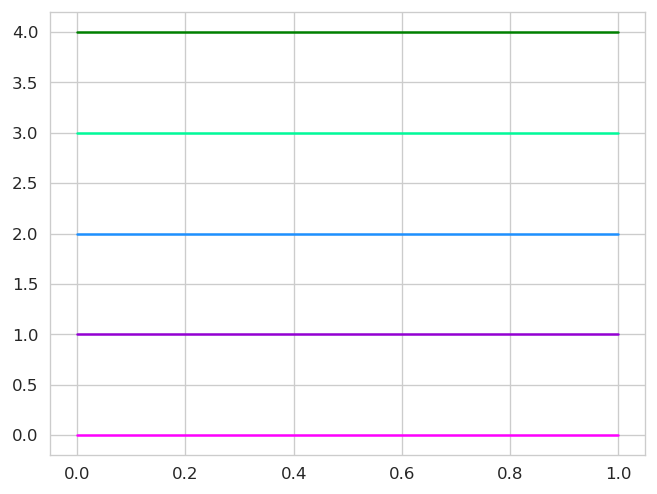

In [3]:
# Set up color palette to use for the five clusters
colors = ['fuchsia',
          'darkviolet',
          # 'navy',
          'dodgerblue',
          'mediumspringgreen',
          'g']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

In [4]:
endo_features = pd.read_csv('Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv', index_col='IID')
endo_features

,abdominal_pelvic_pain,abnormal_cholesterol,asthma,dysmenorrhea,dysuria,fibromyalgia,high_risk_pregnancy_supervision,hypertension,ibs,infertility,irregular_menstruation,leiomyoma_of_uterus,lower_abdominal_pain,migraine,pain_with_sex,pcos,shortness_of_breath
IID,,,,,,,,,,,,,,,,,
PMBB1001462384555,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
PMBB1002857391938,1,0,1,1,0,0,0,1,0,0,1,0,1,1,1,0,0
PMBB1003210639911,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
PMBB1003222496744,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0
PMBB1003626451826,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMBB9993259322112,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
PMBB9994756680249,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0
PMBB9995182887713,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [5]:
pheno = pd.read_csv('Pheno/FULL_PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID', low_memory=False)
pheno = pheno.loc[endo_features.index]

pheno[[c for c in pheno.columns if 'CC3' in c]] = pheno[[c for c in pheno.columns if 'CC3' in c]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

use_pheno = 'ICD_1_with_N80.0'

cases = pheno.index[pheno[use_pheno] == 1]
controls = pheno.index[pheno[use_pheno] == 0]

cases = cases.intersection(endo_features.index)

pheno = pheno[pheno.index.isin(cases) | pheno.index.isin(controls)]

print(len(controls), len(cases))

pheno[use_pheno].fillna('NA').value_counts()

0 4078


1    4078
Name: ICD_1_with_N80.0, dtype: int64

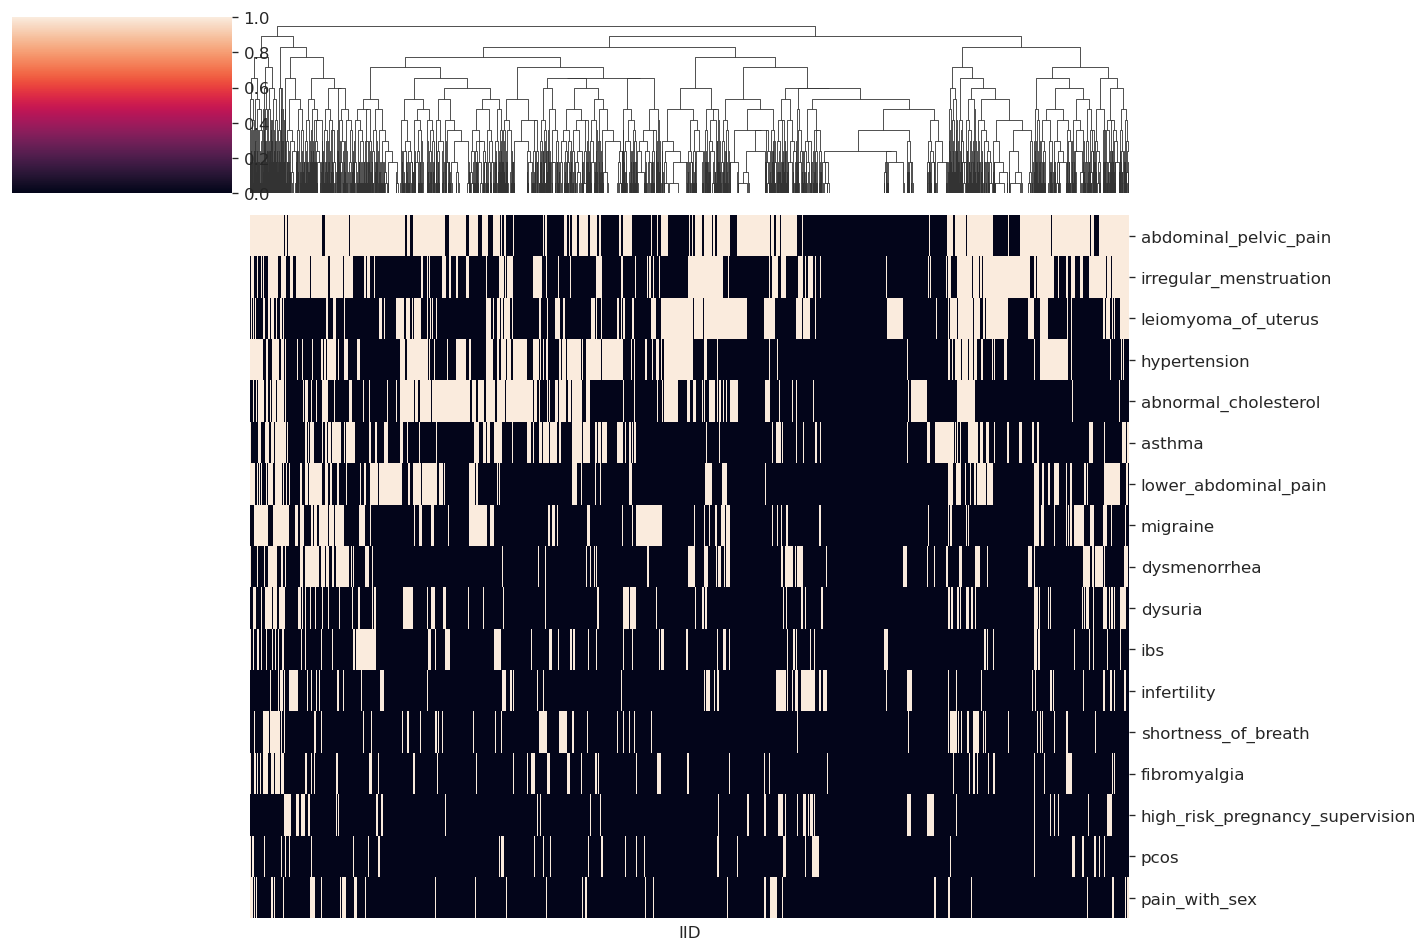

In [6]:
feature_order = endo_features.mean().sort_values(ascending=False).index

sns.clustermap(endo_features[feature_order].transpose(), method='complete', yticklabels=True, metric='cityblock', row_cluster=False, xticklabels=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=5, random_state=314159, assign_labels='cluster_qr')

clusters = pd.Series(model.fit_predict(endo_features), index=endo_features.index) + 1
print(clusters.value_counts().sort_index())

1     441
2     686
3    1151
4     796
5    1004
dtype: int64


In [8]:
clusters.name = 'Cluster'
clusters.to_csv('Data/NG_PMBB_clusters.csv')

In [10]:
tsne = TSNE(n_components=3, init='pca', perplexity=50, random_state=314159, metric='manhattan')
embedding = pd.DataFrame(tsne.fit_transform(endo_features),
                         columns=['TSNE 1', 'TSNE 2', 'TSNE 3'],
                         index=endo_features.index)

/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


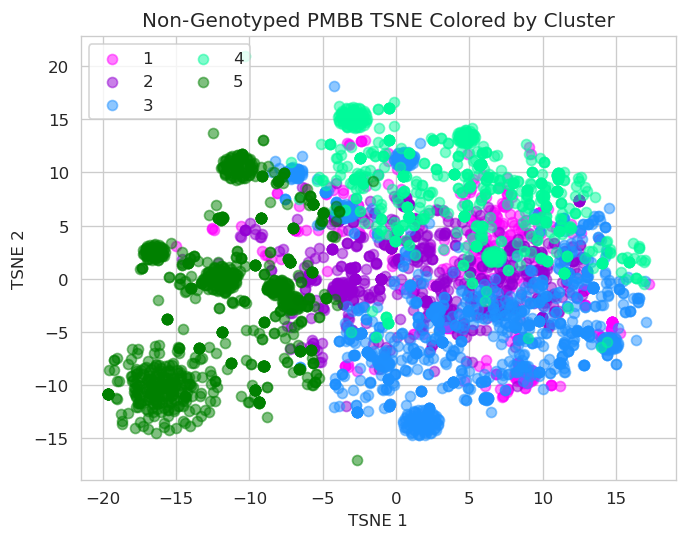

<Figure size 768x576 with 0 Axes>

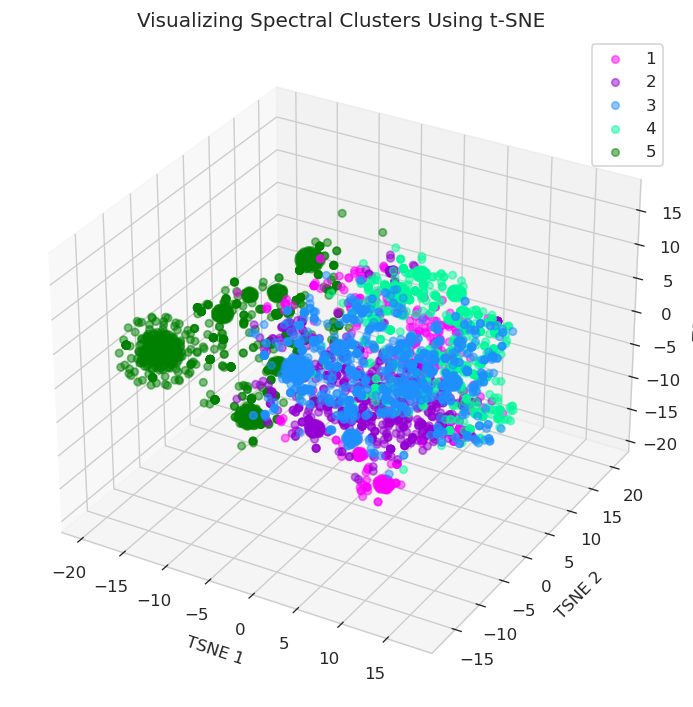

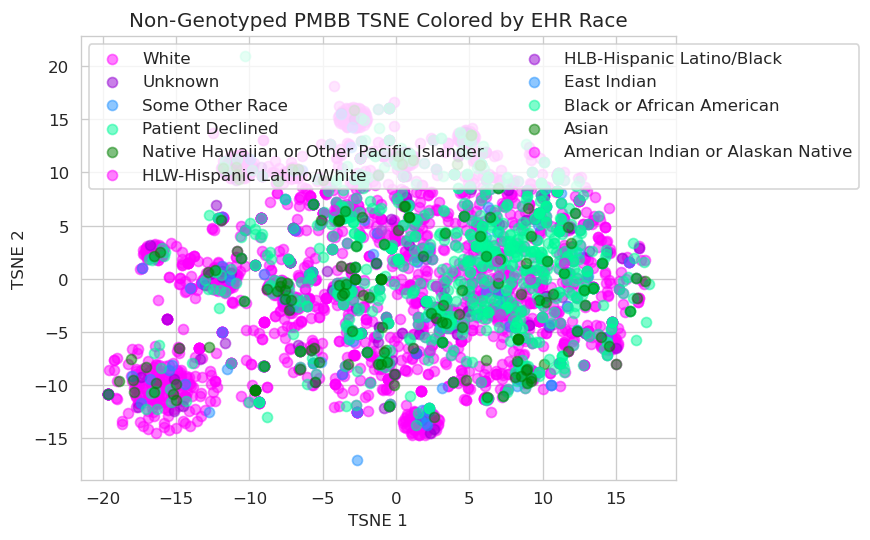

In [12]:
for cluster, subDF in embedding.groupby(clusters):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by Cluster')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Clusters.png', dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_size_inches(8, 6)

for cluster, subDF in embedding.groupby(clusters):
    ax.scatter(subDF['TSNE 1'], subDF['TSNE 2'], subDF['TSNE 3'], label=str(cluster), alpha=0.5)
ax.legend()

ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_zlabel('TSNE 3')

ax.set_title('Visualizing Spectral Clusters Using t-SNE')
plt.tight_layout()

plt.savefig('Plots/tsne_3D_by_cluster.png', bbox_inches='tight')
plt.show()
plt.clf()

race_order = pheno['RACE'].value_counts().sort_index(ascending=False).index

for cluster in race_order:
    subDF = embedding.loc[pheno[pheno['RACE'] == cluster].index.intersection(embedding.index)]
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.legend()
plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by EHR Race')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Race.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
transfer_clusters = KNeighborsClassifier(n_neighbors=3, weights='distance',
                                         metric='manhattan', algorithm='brute')

transfer_clusters.fit(endo_features.loc[clusters.index], clusters)

os.makedirs('Models/', exist_ok=True)
pickle.dump(transfer_clusters, open('Models/non_geno_PMBB_transfer_clusters.pickle', 'wb+'))

test_transfer = pickle.load(open('Models/non_geno_PMBB_transfer_clusters.pickle', 'rb'))
test_transfer.predict(endo_features.loc[clusters.index])

training_y = transfer_clusters.predict(endo_features.loc[clusters.index])

pd.crosstab(clusters, training_y)

col_0,1,2,3,4,5
Cluster,,,,,
1,441,0,0,0,0
2,0,686,0,0,0
3,0,0,1151,0,0
4,0,0,0,796,0
5,0,0,0,0,1004


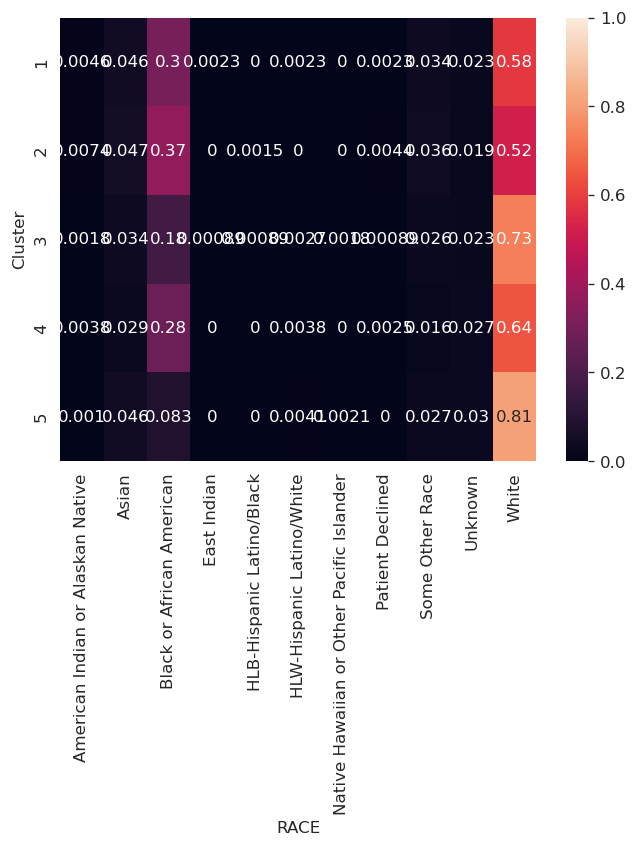

In [13]:
cluster_by_ancestry = pd.crosstab(pheno['RACE'], clusters)
cluster_by_ancestry.columns.name = 'Cluster'
sns.heatmap((cluster_by_ancestry / cluster_by_ancestry.sum()).transpose(),
            vmin=0, vmax=1, annot=True)
plt.show()

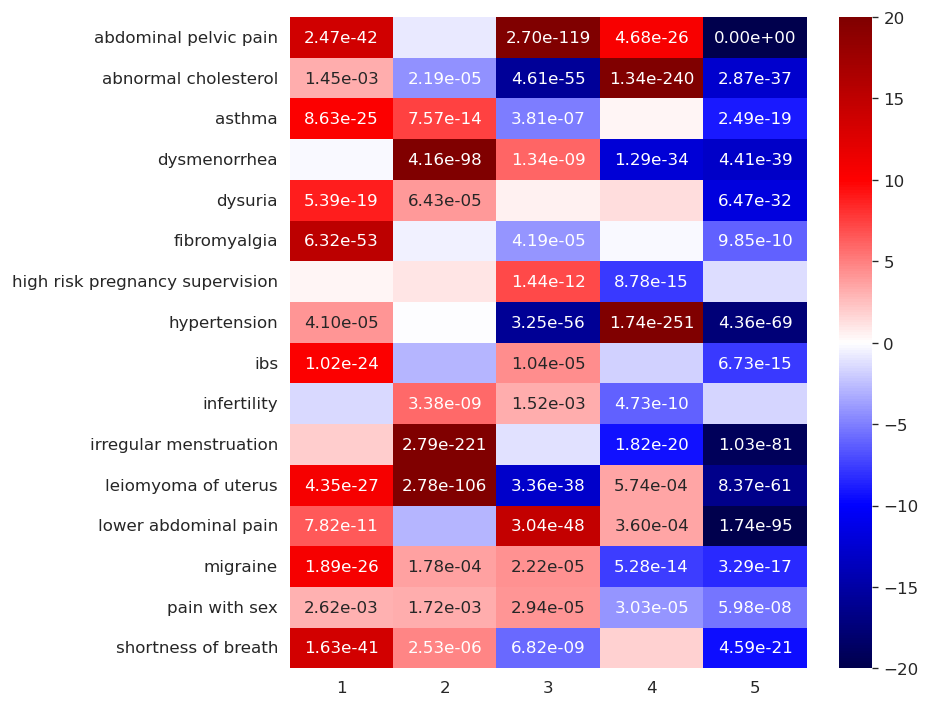

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters.index[clusters == cluster]
    popB = clusters.index[clusters != cluster]

    for trait in endo_features.columns:
        succA = endo_features.loc[popA, trait].sum()
        succB = endo_features.loc[popB, trait].sum()

        nObsA = endo_features.loc[popA, trait].count()
        nObsB = endo_features.loc[popB, trait].count()

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(endo_features.columns)
cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=max(-cluster_ztests.abs().max().max(), -20),
            vmax=min(cluster_ztests.abs().max().max(), 20),
            ax=ax, yticklabels=True)

plt.tight_layout()
plt.savefig('Plots/spectral_clustering_feature_enrichment.png', bbox_inches='tight')
plt.show()

In [15]:
cluster_ztests

,1,2,3,4,5
abdominal pelvic pain,13.635222,-0.864465,23.222547,10.557639,-43.055161
abnormal cholesterol,3.184044,-4.244151,-15.629178,33.124087,-12.756406
asthma,10.280512,7.477662,-5.078392,0.425023,-8.989217
dysmenorrhea,-0.303744,21.021575,6.062435,-12.271574,-13.077767
dysuria,8.903922,3.996416,0.568379,1.385417,-11.757373
fibromyalgia,15.312390,-0.552115,-4.096993,-0.181318,-6.111896
high risk pregnancy supervision,0.407175,0.968706,7.080391,-7.755823,-1.396531
hypertension,4.101806,-0.054995,-15.797340,33.871727,-17.567637
ibs,10.263986,-2.968586,4.408400,-1.780308,-7.789537
infertility,-1.456666,5.912223,3.171397,-6.227912,-1.667017
